![](https://wherobots.com/wp-content/uploads/2023/12/Inline-Blue_Black_onWhite.png)
# <span style="color: #7b73e2;">WherobotsAI Raster Inference - Predicting Bounding Boxes and Segments of Airplanes from an LLM-based Text Query</span>


#### This example demonstrates two models that predict objects from text queries: Segment Anything 2 (SAM2) and Open Vocabulary Object Detection (OWLv2) from Google Deepmind. We'll use these models in **Raster Inference** to identify <span style="color: #7b73e2;">**commercial airplanes**</span> over Miami airport in arial imagery.

## <span style="color: #7b73e2;" >Start WherobotsDB</span>

In [1]:
from sedona.spark import SedonaContext
from sedona.raster_utils.SedonaUtils import SedonaUtils
from sedona.maps.SedonaKepler import SedonaKepler
from pyspark.sql.functions import expr

config = (
    SedonaContext.builder()
    .getOrCreate()
)

sedona = SedonaContext.create(config)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## <span style="color: #7b73e2;">Load Satellite Imagery Efficiently</span>

In this step, we load the satellite imagery to run <span style="color: #7b73e2;">**inference**</span> over. 
The large Miami airport GeoTIFF image is split into tiles and loaded as <span style="color: #7b73e2;">**out-of-database or "out-db" rasters**</span> in **WherobotsDB**.

In [2]:
url = "s3://wherobots-examples/data/naip/miami-airport.tiff"
tile_size = 256
df = sedona.read.format("raster").option("tileWidth", tile_size).option("tileHeight", tile_size).load(url)
df.createOrReplaceTempView("df")
df.show()

+--------------------+---+---+------------------+
|                rast|  x|  y|              name|
+--------------------+---+---+------------------+
|OutDbGridCoverage...|  9| 14|miami-airport.tiff|
|OutDbGridCoverage...|  5|  4|miami-airport.tiff|
|OutDbGridCoverage...| 12| 14|miami-airport.tiff|
|OutDbGridCoverage...|  1|  9|miami-airport.tiff|
|OutDbGridCoverage...| 12|  5|miami-airport.tiff|
|OutDbGridCoverage...| 15| 11|miami-airport.tiff|
|OutDbGridCoverage...|  3| 11|miami-airport.tiff|
|OutDbGridCoverage...| 10|  7|miami-airport.tiff|
|OutDbGridCoverage...| 15| 12|miami-airport.tiff|
|OutDbGridCoverage...|  2| 13|miami-airport.tiff|
|OutDbGridCoverage...|  2|  2|miami-airport.tiff|
|OutDbGridCoverage...| 14|  3|miami-airport.tiff|
|OutDbGridCoverage...| 18|  3|miami-airport.tiff|
|OutDbGridCoverage...|  8|  0|miami-airport.tiff|
|OutDbGridCoverage...| 20| 12|miami-airport.tiff|
|OutDbGridCoverage...| 18|  4|miami-airport.tiff|
|OutDbGridCoverage...| 15| 10|miami-airport.tiff|


## <span style="color: #7b73e2;">Viewing the Model's Imagery Inputs</span>

We can see the footprints of the tiled images with the `SedonaKepler.create_map()` integration. Using `SedonaUtils.display_image()` we can view the images as well.

<span style="color: #7b73e2;;"> **Tip:** </span>  Save the map to a html file using `kepler_map.save_to_html()`

In [3]:
kepler_map = SedonaKepler.create_map()
df = df.withColumn('footprint', expr("ST_TRANSFORM(RS_CONVEXHULL(rast),'EPSG:4326')"))
SedonaKepler.add_df(kepler_map, df=df, name="Image Footprints")

kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Image Footprints': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…

,as
0,
1,
2,
3,
4,

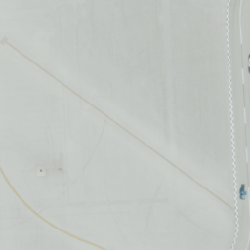
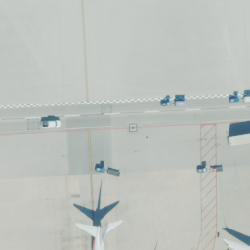
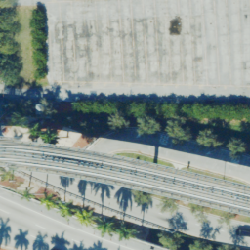
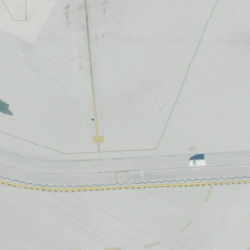
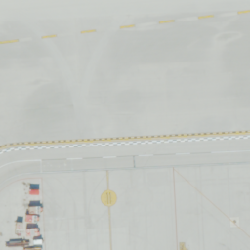

In [4]:
htmlDf = sedona.sql(f"""SELECT RS_AsImage(rast, 250) as FROM df limit 5""")
SedonaUtils.display_image(htmlDf)

## <span style="color: #7b73e2;">Run Predictions and Visualize Results</span>

To run predictions, specify the model to use by the `model id`. Five models are pre-loaded and made available in **Wherobots Cloud**. You can also load your own models, learn more about that process [here](https://docs.wherobots.com/latest/tutorials/wherobotsai/wherobots-inference/raster-inference-overview/?h=bring#bring-your-own-model-guide).

Inference can be run using **Wherobots' Spatial SQL functions**, in this case: `RS_Text_to_Segments()`.
            
Here we generate predictions for all images in the ROI. The predictions output has one label for the text prompt, `1` for a positive prediction. 

Then filter and print some of the results to see how positive detect results look.  

In [5]:
model_id = "sam2"
prompt = "airplanes"
threshold = 0.5

preds = sedona.sql(
    f"""SELECT rast, RS_TEXT_TO_SEGMENTS('{model_id}', rast, '{prompt}', {threshold}) AS preds from df"""
)
preds.cache().count()
preds.createOrReplaceTempView("preds")

## <span style="color: #7b73e2;">Prepare Results</span>

Before plotting our predictions we need to transform our results. 

We need our table in a structure where each row represents _all_ of a raster scene's bounding box predictions to a format where each row represents a _single_ predicted bounding box. 

To do this, combine the list columns containing our prediction results (`max_confidence_bboxes`, `max_confidence_scores`, and `max_confidence_labels`) with `arrays_zip`.  Then use `explode` to convert lists to rows. 

To map the results with `SedonaKepler`, convert the `max_confidence_bboxes` column to a `GeometryType` column with `ST_GeomFromWKT`

In [6]:
preds_filtered = sedona.sql(f"""
  SELECT *
  FROM preds
  WHERE
    size(preds.labels) > 0
    AND array_contains(preds.labels, 1)
    AND NOT array_contains(preds.segments_wkt, 'POLYGON EMPTY')
""")
preds_filtered.createOrReplaceTempView("preds_filtered")
preds_filtered.show()

+--------------------+--------------------+
|                rast|               preds|
+--------------------+--------------------+
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[MULTIPOLYGON ((...|
|OutDbGridCoverage...|{[MULTIPOL

In [7]:
exploded = sedona.sql("""
SELECT
    rast,
    exploded_predictions.*
FROM
    preds_filtered
LATERAL VIEW explode(arrays_zip(preds.segments_wkt, preds.confidence_scores, preds.labels)) AS exploded_predictions
WHERE
    exploded_predictions.confidence_scores != 0.0
""")
exploded.cache().count()
exploded.createOrReplaceTempView("exploded")
exploded.show()

+--------------------+--------------------+-----------------+------+
|                rast|        segments_wkt|confidence_scores|labels|
+--------------------+--------------------+-----------------+------+
|OutDbGridCoverage...|MULTIPOLYGON (((-...|       0.92690235|     1|
|OutDbGridCoverage...|POLYGON ((-80.272...|        0.9711131|     1|
|OutDbGridCoverage...|MULTIPOLYGON (((-...|       0.92451346|     1|
|OutDbGridCoverage...|MULTIPOLYGON (((-...|        0.9354012|     1|
|OutDbGridCoverage...|MULTIPOLYGON (((-...|       0.81421113|     1|
|OutDbGridCoverage...|POLYGON ((-80.274...|        0.9641225|     1|
|OutDbGridCoverage...|POLYGON ((-80.284...|        0.9747454|     1|
|OutDbGridCoverage...|MULTIPOLYGON (((-...|       0.94296753|     1|
|OutDbGridCoverage...|MULTIPOLYGON (((-...|        0.8417237|     1|
|OutDbGridCoverage...|MULTIPOLYGON (((-...|        0.9694099|     1|
|OutDbGridCoverage...|MULTIPOLYGON (((-...|       0.95517844|     1|
|OutDbGridCoverage...|MULTIPOLYGON

## <span style="color: #7b73e2;">Viewing Model Results: Airplane Segmentation Predictions</span>

Just like we visualized the footprints of the tiled images earlier, we can also view our prediction geometries! Highlight a prediction to view it's confidence score. 

In [8]:
kepler_map = SedonaKepler.create_map()
SedonaKepler.add_df(kepler_map, df=exploded, name="Airplane Detections")

kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Airplane Detections': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…

To view results on the underlying imagery used by the model, you can use the `show_detections` function. This function accepts a Dataframe containing an outdb_raster column as well as other arguments to control the plot result. Check out the full docs for the function by calling `show_detections??`

In [9]:
from wherobots.inference.plot.detections import show_detections
show_detections?

Signature:
show_detections(
    df: pandas.core.frame.DataFrame | pyspark.sql.dataframe.DataFrame,
    geometry_column: str = None,
    geometry_crs: str = 'EPSG:4326',
    confidence_threshold: float = 0.05,
    plot_geoms: bool = True,
    side_by_side: bool = True,
) -> None
Docstring:
Plot raster images with detected object geometries overlaid.

This function handles both Pandas and PySpark DataFrames, automatically detecting the raster column.
It is compatible with dataframes returned from a SQL inference function. Exploded dataframes are not
supported.

Args:
    df: Pandas or PySpark DataFrame containing raster data and detection results
    geometry_column: Column name containing WKT geometries (if None, automatically detected)
    geometry_crs: Coordinate reference system of the geometries (default: EPSG:4326)
    confidence_threshold: Minimum confidence score for displaying detections
    plot_geoms: Whether to overlay geometries on the images
    side_by_side: Whether to sho

In [10]:
unpacked_preds_df = sedona.sql("SELECT rast, preds.* FROM preds_filtered")

Too many detections to plot (57). Randomly sampling 3 records to plot.


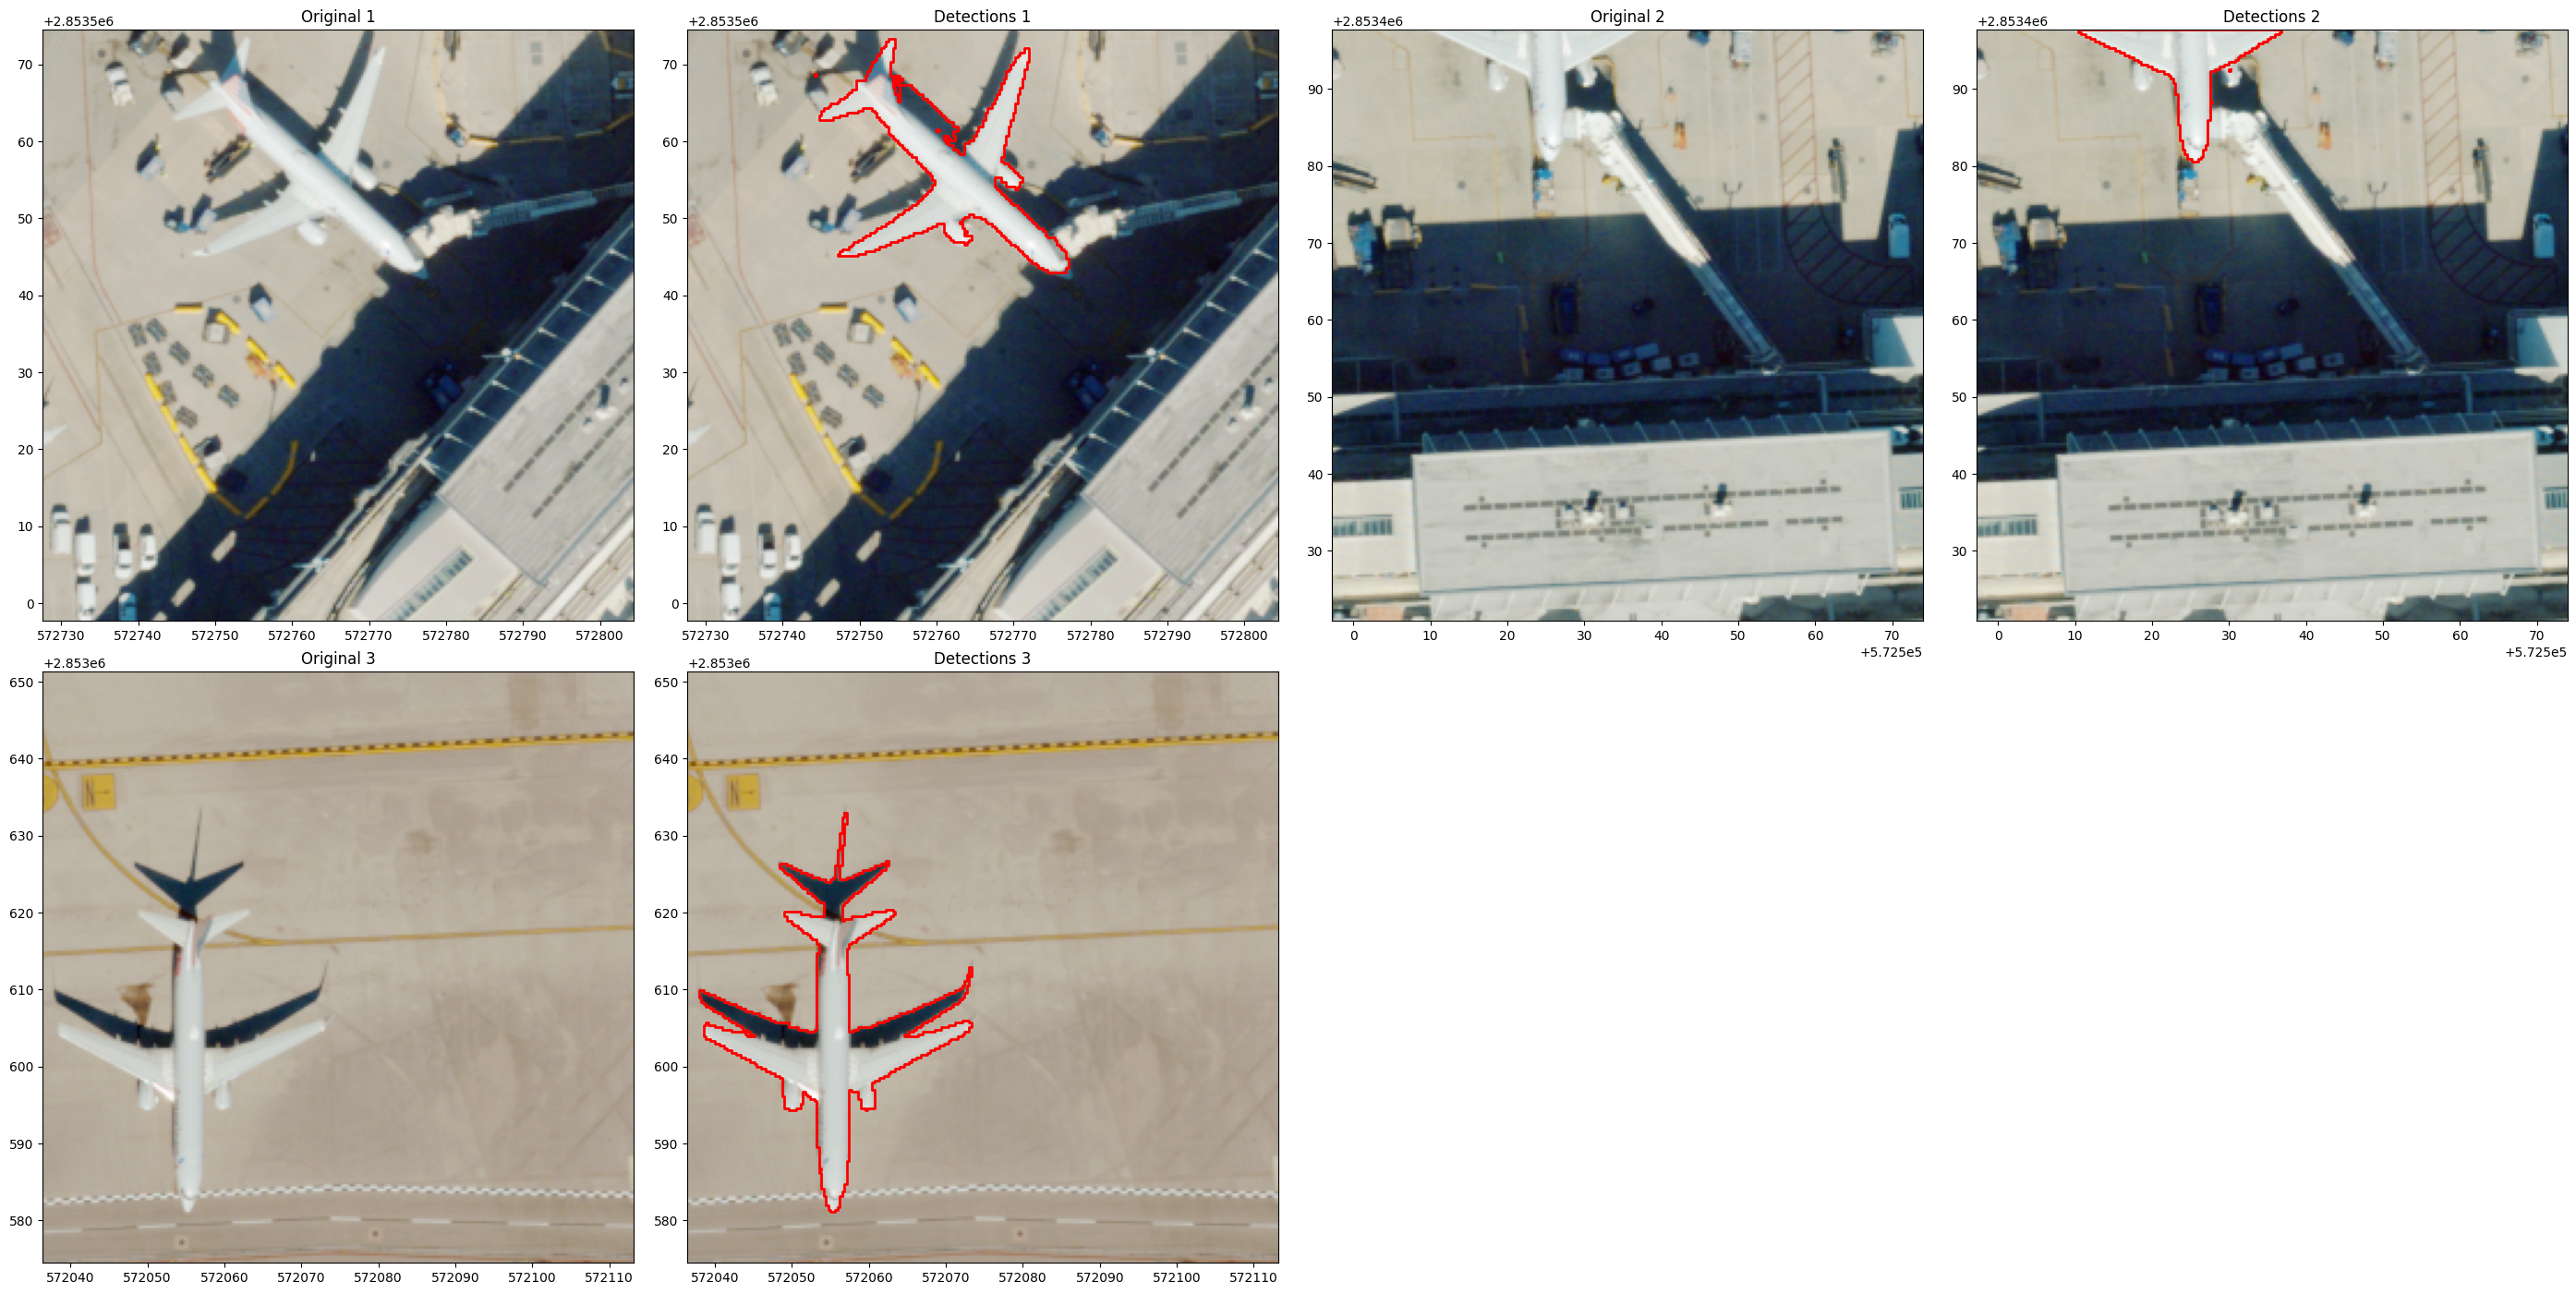

In [11]:
show_detections(
    unpacked_preds_df,
    confidence_threshold=0.7,
    plot_geoms=True,
    geometry_column="segments_wkt",
)

## <span style="color: #7b73e2;">Running Object Detection with a Text Prompt</span>

We can also get bounding box predictions instead of segments using `RS_Text_To_BBoxes`. BBoxes, or boundign boxes, are more useful when you are only concerned with counting and localizing objects rather than delineating exact shape and area with `RS_Text_To_Segments`.

Each of the steps for `RS_Text_To_BBoxes` are the same as `RS_TExt_To_Segments` for generating predictions. The only two changes we need to make are

* using a different hosted model id: `owlv2` instead of `sam2`
* changing our SQL queries that work with the prediction results to work with `bboxes_wkt` column instead of the `segments_wkt` column

In [12]:
model_id = "owlv2"
prompt = "airplanes"
threshold = 0.5

preds = sedona.sql(
    f"""SELECT rast, RS_TEXT_TO_BBoxes('{model_id}', rast, '{prompt}', {threshold}) AS preds from df"""
)
preds.cache().count()
preds.createOrReplaceTempView("preds")

Just like before, we'll filter predictions by labels, remove empty predictions, and show the results in a browsable map and on top of the original imagery for comparison.

In [13]:
preds_filtered = sedona.sql(f"""
  SELECT *
  FROM preds
  WHERE
    size(preds.labels) > 0
    AND array_contains(preds.labels, 1)
    AND NOT array_contains(preds.bboxes_wkt, 'POLYGON EMPTY')
""")
preds_filtered.createOrReplaceTempView("preds_filtered")
preds_filtered.show()

+--------------------+--------------------+
|                rast|               preds|
+--------------------+--------------------+
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON ((-80.2...|
|OutDbGridCoverage...|{[POLYGON 

In [14]:
exploded = sedona.sql("""
SELECT
    rast,
    exploded_predictions.*
FROM
    preds_filtered
LATERAL VIEW explode(arrays_zip(preds.bboxes_wkt, preds.confidence_scores, preds.labels)) AS exploded_predictions
WHERE
    exploded_predictions.confidence_scores != 0.0
""")
exploded.cache().count()
exploded.createOrReplaceTempView("exploded")
exploded.show()

+--------------------+--------------------+-----------------+------+
|                rast|          bboxes_wkt|confidence_scores|labels|
+--------------------+--------------------+-----------------+------+
|OutDbGridCoverage...|POLYGON ((-80.272...|        0.5493802|     1|
|OutDbGridCoverage...|POLYGON ((-80.273...|       0.51149553|     1|
|OutDbGridCoverage...|POLYGON ((-80.281...|       0.60384244|     1|
|OutDbGridCoverage...|POLYGON ((-80.274...|         0.590396|     1|
|OutDbGridCoverage...|POLYGON ((-80.273...|       0.54103434|     1|
|OutDbGridCoverage...|POLYGON ((-80.274...|        0.6244701|     1|
|OutDbGridCoverage...|POLYGON ((-80.284...|       0.65350616|     1|
|OutDbGridCoverage...|POLYGON ((-80.281...|       0.68930304|     1|
|OutDbGridCoverage...|POLYGON ((-80.271...|        0.5591742|     1|
|OutDbGridCoverage...|POLYGON ((-80.270...|         0.529411|     1|
|OutDbGridCoverage...|POLYGON ((-80.271...|        0.5224248|     1|
|OutDbGridCoverage...|POLYGON ((-8

In [15]:
kepler_map = SedonaKepler.create_map()
SedonaKepler.add_df(kepler_map, df=exploded, name="Airplane Detections")

kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Airplane Detections': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…

In [16]:
unpacked_preds_df = sedona.sql("SELECT rast, preds.* FROM preds_filtered")

We see below that OWLv2 and SAM2 do remarkably well at identifying airplanes with little user effort! Before promptable, general-purpose models like these were available, it would be a significant project for an ML Engineering team to arrive at a similar result by developing a model from scratch.

Too many detections to plot (57). Randomly sampling 3 records to plot.


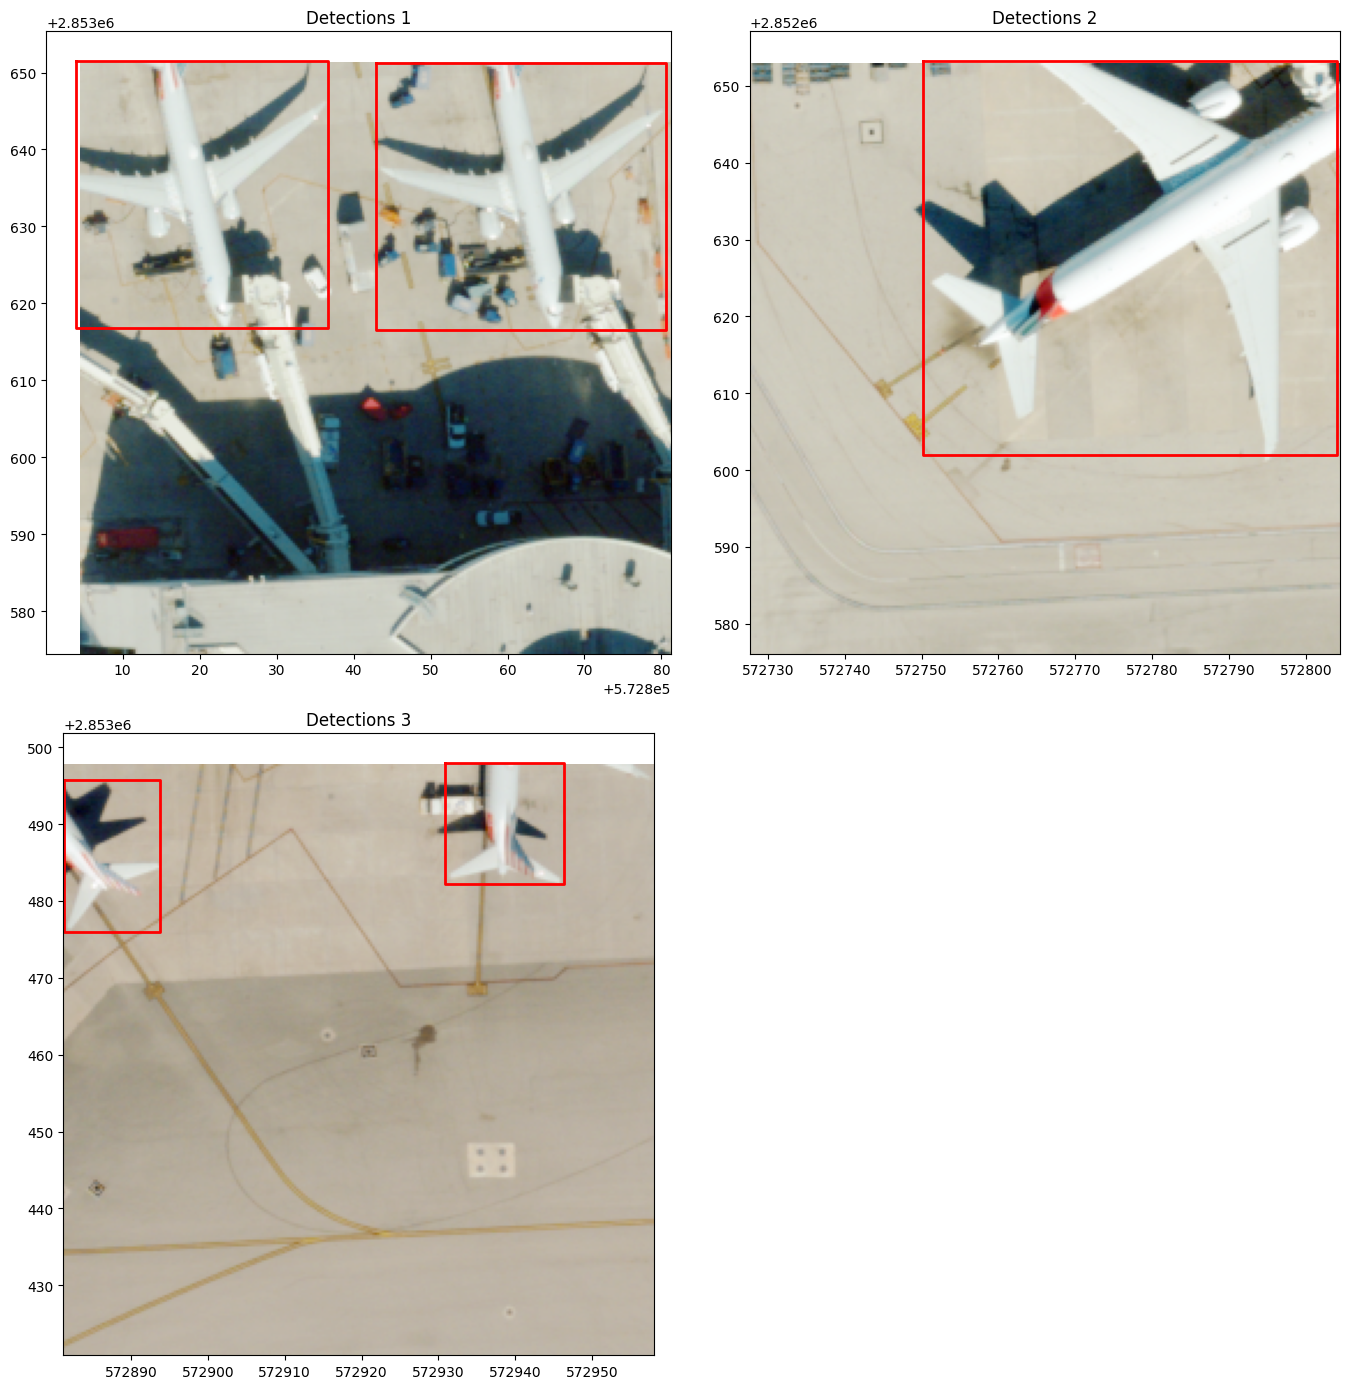

In [17]:
show_detections(
    unpacked_preds_df,
    confidence_threshold=0.5,
    plot_geoms=True,
    side_by_side=False,
    geometry_column="bboxes_wkt",
)

## <span style="color: #7b73e2;">Next Steps with Raster Inference</span>

With access to general-purpose, text-promptable models, what will you predict and georeference next? Some ideas on next things to try include:

* Try to predict different objects besides airplanes in the image tiles above using new text prompts
* Adjust the confidence score threshold for `RS_Text_to_Segments` or `RS_Text_to_BBoxes` to see how SAM2 or OWLv2 respond
* Read a new imagery dataset with our [STAC Reader](https://docs.staging.wherobots.com/latest-snapshot/references/wherobotsdb/vector-data/Stac/) and try to predict a different feature of interest, such as agriculture, buildings, or tree crowns.

We're excited to hear what you're doing with SAM2 and OWLv2! 